AUTHOR: XIAOXIA LIN


# JOKES recommendations

    1. Data exploration
        1.1 Split our data into training set and test set
        1.2 Plotting 
            - number of ratings by users
            - rating distribution
    2. Traditional Neiborhood Collaborative Filtering
        2.1 Item-based
            2.1.1 Similarity
            2.1.2 Prediction
        2.2 User-based   
            2.2.1 Similarity
            2.2.2 Prediction
    3. Content-Based recommender.
    4. Graph-Based recommender system
    5. Evaluation and comparation
        - Whole test set
        - User with less ratings

In [2]:
# import session
import numpy as np
import pandas as pd
import random, re, nltk, codecs, time
import numpy.linalg as LA
from scipy.stats import pearsonr
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from BeautifulSoup import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Data exploration

+ jester-data-1: Data from 24,983 users who have rated 36 or more jokes
+ jester-data-2: Data from 23,500 users who have rated 36 or more jokes
+ jester-data-3: Data from 24,938 users who have rated between 15 and 35 jokes

In [173]:
def getting_data():

    # Create a panda dataframe. 
    df = pd.read_excel('data/jester/jester-data-1.xls',header=None)
    df2 = pd.read_excel('data/jester/jester-data-2.xls',header=None)
    df3 = pd.read_excel('data/jester/jester-data-3.xls',header=None)

    df = pd.concat([df, df2, df3])
    df.index = range(len(df))
    
    
    # get a smaller subset, and split the subset into training set(75%) and test set(25%). 
    random.seed(47)
    df = df.loc[random.sample(df.index, 300)]  
    training = []
    test = []

    training = pd.DataFrame(index=df.index,columns=['items','#items'])
    test = pd.DataFrame(index=df.index,columns=['items','#items'])

    for index,row in df.iterrows():
        row = row[1:]
        l = row[row <11] # removing all 99's, so we obtain items that user rate.   
        training_indexes = random.sample(l.index,int(0.75*(len(l))))
        test_indexes = list(set(l.index) - set(training_indexes))
        test['items'].ix[index] = test_indexes
        test['#items'].ix[index] = len(test_indexes)
        training['items'].ix[index] = training_indexes
        training['#items'].ix[index] = len(training_indexes)
    return df, training, test

In [174]:
df, training, test = getting_data()

print df.shape
df.head(3)

(300, 101)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
25832,71,2.67,4.17,-4.17,-6.26,0.44,5.00,-7.09,-1.17,-1.31,...,-1.50,99.00,99.0,99.0,99.00,99.00,99.00,99.00,99.00,99.00
31584,100,-0.87,-4.32,2.38,-8.20,4.37,-0.78,-8.98,1.99,-4.22,...,1.12,1.17,-0.1,-3.5,-7.72,-4.27,-1.65,7.18,-5.53,-9.42
33308,65,3.16,-3.30,1.21,99.00,-3.35,0.78,-2.82,1.12,99.00,...,99.00,99.00,99.0,99.0,99.00,0.00,8.83,99.00,99.00,99.00


- The first col is the number of rated items by user. 
- Continuous ratings from -10 to 10. (99 means missing value)

In [12]:
print training.shape
training.head(3)

(300, 2)


,items,#items
25832,"[5, 42, 17, 59, 6, 34, 47, 91, 8, 25, 22, 58, ...",53
31584,"[92, 52, 68, 12, 89, 19, 3, 46, 85, 62, 70, 7,...",75
33308,"[10, 22, 5, 16, 58, 36, 42, 3, 67, 65, 56, 29,...",48


In [13]:
print test.shape
test.head(3)

(300, 2)


,items,#items
25832,"[68, 66, 67, 4, 40, 10, 11, 12, 45, 61, 16, 51...",18
31584,"[6, 9, 14, 22, 27, 28, 32, 35, 36, 38, 40, 41,...",25
33308,"[32, 97, 2, 35, 8, 60, 11, 12, 14, 47, 21, 25,...",17


### 1.2 Plotting

#### 1.2.1 Some plots to get an idea of how our data is distributed

Our sample data is very similar to our original data in term of the number of ratings by users.

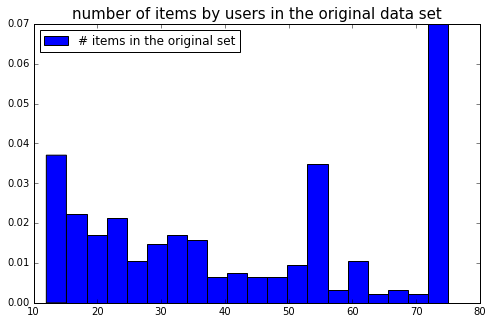

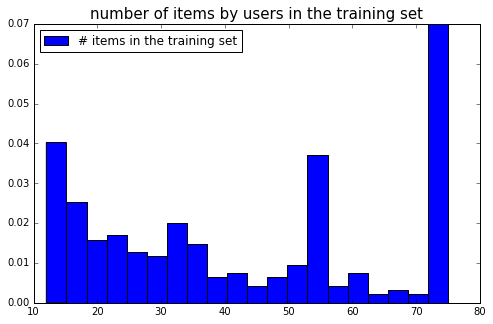

In [11]:
plt.figure(figsize=(8, 5))
plt.hist(df[0]*0.75, bins=20, normed=True, label='# items in the original set')
plt.legend(loc = "upper left")
plt.title('number of items by users in the original data set', fontsize=15)

plt.figure(figsize=(8, 5))
plt.hist(training['#items'], bins=20, normed=True, label='# items in the training set',)
plt.legend(loc = "upper left")
plt.title('number of items by users in the training set', fontsize=15)

#### 1.1.2 some rating distribution

We can see there is a huge variety of ratings distribution. It is hard to get any conclusion just by looking on those plots.

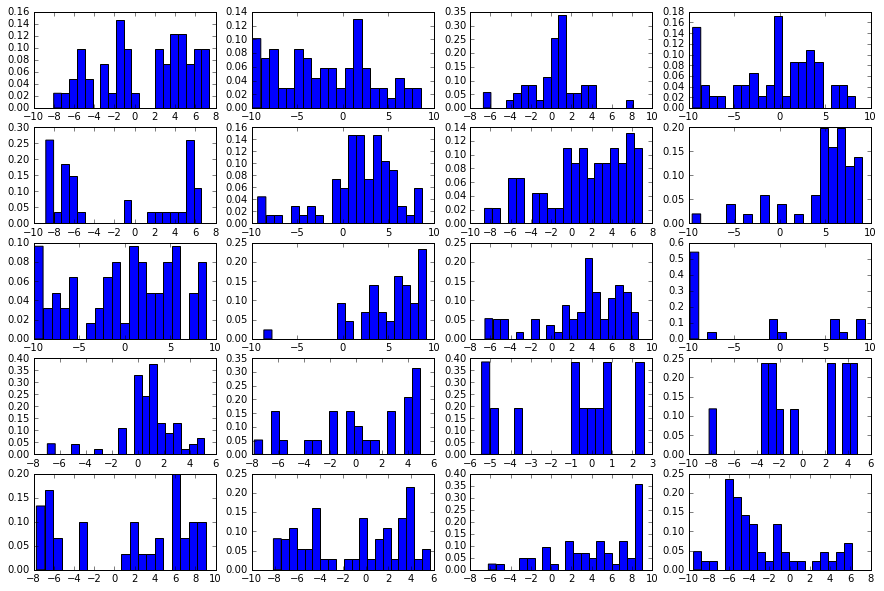

In [12]:
users_id = [index for index, rows in training.iterrows()]
fig = plt.figure(figsize=(15,10))
for num, user in enumerate(users_id[:20]):
    y = fig.add_subplot(5,4,num+1)
    rating = [df.ix[user, i] for i in training.ix[user,0]]
    plt.hist(rating, bins=20, normed=True, label='# ratings')
# plt.title('number of ratings by users', fontsize=15)   
plt.show()

## 2. Traditional Neiborhood Collaborative Filtering


In [14]:
def average_rating_by_user(u):
    rated_item = training.ix[u,0]
    ratings = np.array([df.ix[u,i] for i in rated_item])
    return np.mean(ratings)

# unit test for the average_rating_by_user function
users = [index for index, rows in training.iterrows()]
for idx, user in enumerate(users[:3]):
    print "user %s: average rating %.2f"%(user, average_rating_by_user(user))

user 25832: average rating 0.97
user 31584: average rating -1.97
user 33308: average rating 0.31


In [15]:
def average_rating_of_item(item):
    ratings = [df.ix[u, item] for u in users if df.ix[u,item] <11]
    return round(sum(ratings)/len(ratings),4)

for i in range(1,4):   # item are from 1 to 100
    print "item %2d has average rating %.2f" %(i,average_rating_of_item(i))

item  1 has average rating 0.56
item  2 has average rating -0.26
item  3 has average rating 0.57



## 2.1 *Item-based models*: 
Similar items are rated in a similar way by the same user.

### 2.1.1 Similarity between item $i$ and item $j$, computed by all the users who have rated both items.

$$ sim(i,j) = \frac{\sum_{u \in {U_i \cap U_j}} (R_{u,i}-\bar{R_u})(R_{u,j}-\bar{R_u})}{\sqrt{\sum_{u \in {U_i \cap U_j}} (R_{u,i}-\bar{R_u})^2}\sqrt{\sum_{u \in {U_i \cap U_j}} (R_{u,j}-\bar{R_u})^2})}$$

- $ u \in {U_i \cap U_j} $ :users who have rated both item $i$ and item $j$
- $ \bar{R_u} $: average rating by user $u$

In [16]:
# find users who have rated both item1 and item2
def common_users_for_items(item1, item2):
    user_df = df[[item1,item2]].ix[df[item1]<11].ix[df[item2]<11]
    common_users = [index for index, rows in user_df.iterrows()]
#     print "Item %d and item %d have %d common users" %(item1,item2,len(common_users))
    return user_df, common_users


# Unit test for common_users_for_items function
common_users_df, common_users = common_users_for_items(1, 2)
print common_users[:10]

[25832, 31584, 33308, 25217, 28811, 3003, 30729, 1737, 19368, 35356]


In [17]:
def item_similarity_f(item1, item2):
    common_users_df,common_users = common_users_for_items(item1, item2)
    numerador, den1, den2 = 0,0,0
    for user in common_users:
        user_average_rating = average_rating_by_user(user)
        user_item1_rating = df.ix[user, item1] 
        user_item2_rating = df.ix[user, item2] 
        numerador += (user_item1_rating - user_average_rating)*(user_item2_rating - user_average_rating)
        den1 += (user_item1_rating - user_average_rating)**2
        den2 += (user_item2_rating - user_average_rating)**2
        
    sim = numerador/(np.sqrt(den1)*np.sqrt(den2)) 
    return sim 

# Unit test for item_similarity function
item1 = 4
item2 = 7
print item_similarity_f(item1, item2)
item_similarity_f(item1, item2) == item_similarity_f(item2, item1) 

0.15496194838 True


In [17]:
def item_sim_dict(training):
    sim={}
    for item in range(1,100):
        sim.setdefault(item, {})
        for other_item in range(item, 101):
            sim.setdefault(other_item, {})
            sim[item][other_item]= item_similarity_f(item, other_item) if item_similarity_f(item, other_item)>0 else 0
    return sim

In [18]:
# saving
item_sim_dictionary = item_sim_dict(training)
np.save('item_sim_dictionary.npy', item_sim_dictionary)

In [100]:
# loading
similarity = np.load('item_sim_dictionary.npy')

item_sim_df = pd.DataFrame(similarity.item())
item_sim_df.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
1,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.165591,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.084262,0.044463,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.161872,0.337054,0.148856,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.100000,0.106118,0.022914,0.115682,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.1.2 Prediction function

Let the top-k matching items to item $i$, for which the user $u$ has specified ratings, be denoted by $Q_i(u)$. The *weighted* average value of these (raw) ratings is reported as the predicted values.


$$ \hat{r}_{ui} = \frac{ \sum_{j \in Q_i(u) } sim(i,j) r_{uj}    }{  \sum_{j \in Q_i(u) } |sim(i,j)|   } $$

In [20]:
# off-line
def item_based_collaborative_pred(user, item, k=7):
    '''
    given the user, and item, and the number of minimum common items,
    it returns the predicted rating
    '''
    rated_item = [i for i in training.ix[user,0] if i!=item]
#     print "\nUser have rated %d item: "%len(rated_item),rated_item 
    similar_items = [(i, item_sim_df[i][item]) if i<item else (i, item_sim_df[item][i]) for i in rated_item ]
    similar_items.sort(key=lambda x: x[1], reverse=True)
    num,den = 0,0
#     print "\nThe most similar items to item %d that user have rated:"%item
    for i in similar_items[:k]:    
        num += i[1]*df.ix[user,i]
        den += np.absolute(i[1])
#     print "(user %6d, item %3d)"%(user,item),"pred_rating: %.5f"%(num/den), " ----vs---- real rating: %.5f"%df.ix[user,item]
    return num/den


# online 
def item_based_collaborative_pred2(user, item, k=7):
    rated_item = [i for i in training.ix[user,0] if i!=item]
    similar_items = [(i, item_similarity_f(i, item)) for i in rated_item ]
    similar_items.sort(key=lambda x: x[1], reverse=True)
    num,den = 0,0
    for i in similar_items[:k]:    
        num += i[1]*df.ix[user,i]
        den += np.absolute(i[1])
#     print  "(user %6d, item %3d)"%(user,item),"pred_rating: %.5f"%(num/den), " ----vs---- real rating: %.5f"%df.ix[user,item]
    return num/den

comparing on-line and off-line methods. For the purpose of this exercise, we definitely want to do it off-line!


In [22]:
start_time = time.time()
print item_based_collaborative_pred(users[1], 7, k=7)
print  "off-line prediction took: -- %.4f sec\n" % float((time.time() - start_time))

start_time = time.time()
print item_based_collaborative_pred2(users[1], 7, k=7)
print  "on-line prediction took:-- %.4f sec" % float((time.time() - start_time))

-3.41839244874
off-line prediction took: -- 0.0081 sec

-3.41839244874
on-line prediction took:-- 12.5024 sec


## 2.2 *User based model*: 
Similar users have similar ratings on the same item.

### 2.2.1 Similarity 
Person correlation:

$$ sim(u,v) = \frac{\sum_{i \in I} (R_{u,i}-\bar{R_u})(R_{v,i}-\bar{R_v})}{\sqrt{\sum_{i \in I} (R_{u,i}-\bar{R_u})^2}\sqrt{\sum_{i \in I} (R_{v,i}-\bar{R_v})^2})}$$

where: 
- $u,v$: users
- $ I = I_u \cap I_v$  is the common items set for user $u$ and user $v$.
- $R_{u,i}$:  rating from user u for the item $i \in I$.
- $ \bar R_{u} $: mean rating from the user $u$.

In [21]:
def SimPearson(user1,user2,min_common_items=1):
    ''' 
    Returns a pearsonCorrealation-based similarity score for user1 and user2
    specifying the minimum number of common items. 
    '''
    items_user1 = training.ix[user1,0]
    items_user2 = training.ix[user2, 0]
    common_items = [i for i in items_user1 if i in items_user2]
  
    if(len(common_items)<min_common_items):return 0  
    
    rating_1 = [df.ix[user1, i] for i in common_items]
    rating_2 = [df.ix[user2, i] for i in common_items]
    res= round(pearsonr(rating_1,rating_2)[0],4)

    return res

In [102]:
# compute the similarity dictionary.
# since it is simetric, we can save half of the computating time and memory. 

def user_sim_dict(training):
    users = sorted([index for index, rows in training.iterrows()])
    # print users
    sim = {}
    for idx, user1 in enumerate(users[:len(users)-1]):
        sim.setdefault(user1, {})  
        for user2 in users[idx:len(users)]:  
            sim.setdefault(user2, {})
            sim[user1][user2]= SimPearson(user1,user2,min_common_items=10)\
                            if SimPearson(user1,user2,min_common_items=10)>0\
                            else 0
    return sim

In [ ]:
# saving
user_sim_dict_300 = user_sim_dict(training)
np.save('user_sim_dict_300.npy', user_sim_dict_300)

In [103]:
# loading
similarity = np.load('user_sim_dict_300.npy')
# print similarity

sim_df = pd.DataFrame(similarity.item())
sim_df.head()

,33,327,519,733,1521,1632,1658,1693,1737,2020,...,70348,70656,70708,70893,71279,71547,72035,72346,72660,72965
33,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327,0.2459,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
519,0.0058,0.2039,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
733,0.0000,0.2482,0.1716,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1521,0.4095,0.0552,0.2263,0.6713,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
def most_similar_users_who_has_rated_item(u,item, k=10):
    users = [index for index, rows in training.iterrows()]
    users = [vot_u for vot_u in users if df.ix[vot_u,item]<11 and vot_u!=u]
    users_and_similarity = [(others,sim_df[u][others]) if others>u else (others,sim_df[others][u]) for others in users]
    users_and_similarity = [(u,s) for (u,s) in users_and_similarity if s>0]
    users_and_similarity.sort(key=lambda x: x[1],reverse=True)
    return users_and_similarity[:k]

In [105]:
# unit test. Take any user, and take any item from this user in the test set. 
user = users[1]
item = test.ix[user,0][1]
print user, item
most_similar_users_who_has_rated_item(user,item,k=10)

31584 9


[(8984, 0.58760000000000001),
 (8379, 0.56240000000000001),
 (2590, 0.55869999999999997),
 (12971, 0.53969999999999996),
 (45084, 0.4829),
 (26639, 0.47020000000000001),
 (33907, 0.46960000000000002),
 (31907, 0.46539999999999998),
 (40991, 0.46529999999999999),
 (38418, 0.45600000000000002)]

### 2.2.2 Prediction function

Let $P_u(j)$ be the set of $k$ closest users to target user $u$, who have specified ratings for item $j$. Users with very low or negative correlations with target user $u$ are sometimes filtered from $P_u(j)$ as a heuristic enhancement. Then the overall neghborhood-based *prediction funtion* is as follows:
 
$$\hat{r}_{u,j} = \bar{r}_u + \frac{\sum_{v \in P_u(j)} sim(u,v) (r_{v,j} - \bar{r}_v) }{       \sum_{v \in P_u(j)} |sim(u,v)|}   $$

In [25]:
def user_based_collaborative_pred(user, item, k=10):
    num = 0
    den = 0
    users = [index for index, rows in training.iterrows()]

    most_similar_users = most_similar_users_who_has_rated_item(user, item, k)
    aver_rating = average_rating_by_user(user)

    for (other_user, sim) in most_similar_users:
        aver_rating_user = average_rating_by_user(other_user)
        num += sim * float(df.ix[other_user,item] - aver_rating_user)
        den += np.abs(sim)
    #     print "similar user", other_user, aver_rating_user,df.ix[other_user,item], num,den
        if den==0:
            if average_rating_of_item(test_item)>0: 
                # return the mean item rating if there is no similar for the computation
                pred_rating = average_rating_of_item(item)          
            else:    # else return mean user rating
                pred_rating = average_rating_by_user(other_user)       
    pred_rating = aver_rating + num/den
#     print "(user %6d, item %3d)"%(user,item), "pred_rating: %.5f"%pred_rating, " ----vs---- real rating: %.5f"%df.ix[user,item]
    return pred_rating

user_based_collaborative_pred(user, item, 10)

-0.6613760959888042

## 3. Content-Based recommender

Content-based recommender systems try to match users to items that are similar to what they have liked in the past. This similarity is not necessarily based on rating correlations across users but on the basis of the attributes of the objects liked by the user. Unlike collaborative systems, which explicitly leverage the ratings of other users in addition to that of the target user, content-based systems largely focus on the target user’s own ratings and the attributes of the items liked by the user. Therefore, the other users have little, if any, role to play in content-based systems. In other words, the content-based methodology leverages a different source of data for the recommendation process.


Content-based methods have some advantages in making recommendations for new items, when sufficient rating data are not available for that item. This is because other items with similar attributes might have been rated by the active user. Therefore, the su-
pervised model will be able to leverage these ratings in conjunction with the item attributes to make recommendations even when there is no history of ratings for that item.

In [106]:
def joke_dictionary_buider():
    joke_dic={}
    for i in range(1,101):
        f=codecs.open("./data/jester/jokes/init%d.html"%i, 'r', 'utf-8')
        joke =  f.read()
        for j in re.findall('<!--begin of joke -->(.*)<!--end of joke -->', joke, re.S):
            cleantext = BeautifulSoup(j).text.lower()
        joke_dic[i] = cleantext
    return joke_dic

# Convert to dataframe
joke_dic = joke_dictionary_buider()
joke_df = pd.DataFrame.from_dict(joke_dic, orient='index').reset_index()

# Clean up column names
joke_df.rename(columns={'index': 'joke_index', 0: 'joke_text'}, inplace=True)
joke_df.head()

,joke_index,joke_text
0,1,"a man visits the doctor. the doctor says ""i ha..."
1,2,this couple had an excellent relationship goin...
2,3,q. what's 200 feet long and has 4 teeth?a. the...
3,4,q. what's the difference between a man and a t...
4,5,q.\twhat's o. j. simpson's internet address?a....


In [34]:
def content_sim_buider(df):

    SIMKEY = {}
    tf = TfidfVectorizer(analyzer='word',
                         ngram_range=(1, 3),
                         min_df=0,
                         stop_words='english')
    tfidf_matrix = tf.fit_transform(df['joke_text'])
    cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

    for idx, row in df.iterrows():

        SIMKEY.setdefault(idx+1, {})
        similar_indices = cosine_similarities[idx].argsort()[:-101:-1]
        similar_items = [(cosine_similarities[idx][i], df['joke_index'][i])
                         for i in similar_indices]
        for i in similar_indices:
            SIMKEY[idx+1][df['joke_index'][i]]=cosine_similarities[idx][i] 
        # First item is the item itself, so remove it.
        # This 'sum' is turns a list of tuples into a single tuple:
        # [(1,2), (3,4)] -> (1,2,3,4)
        flattened = sum(similar_items[1:], ())
    return SIMKEY

In [35]:
# saving
np.save('content_based_sim_dictionary.npy', content_sim_buider(joke_df))

In [36]:
# loading
content_based_sim_dictionary = np.load('content_based_sim_dictionary.npy')

# convert to data frame
content_based_sim_df = pd.DataFrame(content_based_sim_dictionary.item())
content_based_sim_df.head(10)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
1,1.000000,0.000000,0.0,0.022728,0.0,0.002625,0.000000,0.0,0.008334,0.007320,...,0.000000,0.012228,0.000000,0.019716,0.000000,0.000000,0.005506,0.000000,0.000000,0.000000
2,0.000000,1.000000,0.0,0.000000,0.0,0.009208,0.000000,0.0,0.000000,0.000000,...,0.000000,0.005402,0.023820,0.000000,0.000000,0.019035,0.017067,0.000000,0.000000,0.000000
3,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.022728,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013465,0.000000,0.000000,0.016740
5,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.002625,0.009208,0.0,0.000000,0.0,1.000000,0.000000,0.0,0.009064,0.016657,...,0.020474,0.037902,0.016121,0.011874,0.000000,0.000000,0.003001,0.000000,0.065688,0.010234
7,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.077189,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.000000,...,0.008306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.008334,0.000000,0.0,0.000000,0.0,0.009064,0.000000,0.0,1.000000,0.003993,...,0.009408,0.011113,0.003488,0.016038,0.005524,0.000000,0.003004,0.007114,0.000000,0.000000
10,0.007320,0.000000,0.0,0.000000,0.0,0.016657,0.077189,0.0,0.003993,1.000000,...,0.011417,0.000000,0.000000,0.014800,0.000000,0.000000,0.008366,0.000000,0.000000,0.000000


In [29]:
def content_based_collaborative_pred(user, item, k=7):
    '''
    given the user, and item, and the number of minimum common items,
    it returns the predicted rating
    '''
    rated_item = [i for i in training.ix[user,0] if i!=item]
#     print "\nUser %d have rated %d item: "%(user,len(rated_item)) #,rated_item 
    similar_items = [(i, content_based_sim_df[i][item]) for i in rated_item ]
    similar_items.sort(key=lambda x: x[1], reverse=True)
    num,den = 0,0
#     print "\nThe most similar items to item %d that user have rated:"%item
    for i in similar_items[:k]: 
        num += i[1]*df.ix[user,i]
        den += np.absolute(i[1])
    if den == 0:
        return average_rating_of_item(item)
#     print "(user %6d, item %3d)"%(user,item),"pred_rating: %.5f"%(num/den), " ----vs---- real rating: %.5f"%df.ix[user,item]
    else: return num/den

# 4. Graph-Based Recommendation System

### 4.1 Item-Item graph

In [32]:
# create a dictionary of counts
def common_user_count_dict_buider(common_users_for_items):
    common_user_count = {}
    for item1 in range(1,101):
        common_user_count.setdefault(item1, {})  
        common_user_count[item1][item1] = 0
        for item2 in range(item1+1, 101):
            common_user_count.setdefault(item2, {})
            _,common_users = common_users_for_items(item1, item2)
            common_user_count[item1][item2] = len(common_users)
            common_user_count[item2][item1] = len(common_users)
    return common_user_count

# saving
common_user_count = common_user_count_dict_buider(common_users_for_items)
np.save('common_user_count_dict.npy', common_user_count)

In [77]:
# loading
common_user_count_dict = np.load('common_user_count_dict.npy')

# convert to dataframe
item_item_graph_df = pd.DataFrame(common_user_count_dict.item())

# normalize the dataframe to be column stochastic
for i in range(1,101):   
    item_item_graph_df[i] /= sum(item_item_graph_df[i]) 
item_item_graph_df.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
1,0.000000,0.010971,0.011196,0.011193,0.007783,0.010021,0.007783,0.007783,0.011195,0.010110,...,0.009792,0.009970,0.009779,0.009913,0.009705,0.010028,0.009778,0.010173,0.010292,0.010563
2,0.011591,0.000000,0.011633,0.011466,0.008437,0.010786,0.008437,0.008437,0.011377,0.010882,...,0.009792,0.010086,0.009895,0.009913,0.010048,0.010028,0.010119,0.010401,0.010402,0.010563
3,0.011325,0.011138,0.000000,0.011375,0.007902,0.010174,0.007902,0.007902,0.011195,0.010265,...,0.009792,0.009970,0.009779,0.009913,0.009820,0.010028,0.009778,0.010287,0.010292,0.010563
4,0.010883,0.010552,0.010933,0.000000,0.007486,0.009639,0.007486,0.007486,0.011104,0.009724,...,0.009673,0.010086,0.009779,0.009913,0.009820,0.009911,0.009665,0.010287,0.010073,0.010563
5,0.011591,0.011892,0.011633,0.011466,0.000000,0.012622,0.017824,0.017824,0.011468,0.012503,...,0.011822,0.011941,0.012107,0.011447,0.011875,0.011544,0.011711,0.011201,0.011497,0.010563


In [72]:
def personalized_page_rank(df, user, A, 
                           alpha=0.9, 
                           tolerance = 10**-15, 
                           max_iterations = 20, 
                           x0 = (1./100)*np.ones((100,1))):
    '''
    df: dataframe of all the ratings
    A: the adjacent matrix
    x0: initial point 
    alpha:  The probability of a teleportation into the node is exactly α/n, 
            (where n is the number of items rated by user)
    return: the orderd list of items with their probability of been reached by user
    '''
    lista = [i for i in range(1,101) if df.ix[user][i]<11]
    e_user = np.zeros((int(100),1))
    e_user[[i-1 for i in lista]] = 1
    n = int(sum(e_user))
    difference = 1
    itera =0

    while difference > tolerance and itera < max_iterations: 
        itera +=1 
        x1 = alpha/n* e_user + (1-alpha)*np.dot(A,x0)
        difference = LA.norm(x1-x0,np.inf)
        x0=x1
#     print "iteration" , itera, ", sum of the vector", sum(x1.flatten())
    return x1.flatten()   

In [89]:
# top k items voted by user
users = [index for index, rows in training.iterrows()]
user = users[1]
item = test.ix[user,0][2]  

A = item_item_graph_df.as_matrix()
x1= personalized_page_rank(df, user, A)
order_list = [(i+1,x1[i]) for i in range(len(x1))]
print order_list[:3]
order_list.sort(key=lambda x: x[1], reverse=True)
pr_items = [it for (it,p) in order_list if df.ix[user,it]<11]
pr_prob = [p for (it,p) in order_list if df.ix[user,it]<11]
print "top 10 items voted by user %d are:"%user,pr_items
print len(pr_items)
print "with correspond probability:",pr_prob[:10]

[(1, 0.0099364826595181952), (2, 0.0099833245623986502), (3, 0.0099463206740789175)]
top 10 items voted by user 31584 are: [5, 7, 8, 13, 15, 16, 17, 18, 19, 20, 50, 36, 53, 27, 29, 35, 32, 62, 68, 69, 66, 49, 65, 31, 21, 61, 54, 56, 42, 48, 28, 46, 26, 39, 40, 38, 14, 12, 11, 47, 22, 45, 34, 63, 6, 52, 25, 10, 70, 55, 23, 51, 41, 64, 43, 59, 60, 2, 67, 30, 37, 33, 3, 57, 1, 24, 58, 4, 9, 44, 99, 97, 98, 95, 92, 93, 96, 94, 91, 100, 88, 86, 90, 84, 89, 87, 76, 83, 80, 82, 81, 85, 78, 72, 79, 73, 71, 75, 77, 74]
100
with correspond probability: [0.010329557324363239, 0.010329557324363239, 0.010329557324363239, 0.010329557324363239, 0.010329557324363239, 0.010329557324363239, 0.010329557324363239, 0.010329557324363239, 0.010329557324363239, 0.010329557324363239]


In [96]:
def graph_based_collaborative_pred(user,item, k=10):
    
    rated_item = [i for i in training.ix[user,0] if i!=item]
    A = item_item_graph_df.as_matrix()
    x1= personalized_page_rank(df, user, A)
    item_prob = [(i+1,x1[i]) for i in range(len(x1)) if i in rated_item]
    item_prob.sort(key=lambda x: x[1], reverse=True)
    
    num,den = 0,0
#     print "\nThe most similar items to item %d that user have rated:"%item
    for i in item_prob[:k]:    
        num += i[1]*df.ix[user,i]
        den += np.absolute(i[1])
#     print "(user %6d, item %3d)"%(user,item),"pred_rating: %.5f"%(num/den), " ----vs---- real rating: %.5f"%df.ix[user,item]
    return num/den

### 4.2 User-Item graph

In [232]:
df_rating_bool
df_rating_bool = (df.iloc[:,1:101]<11)*1    # True if there is rating
pos_rating_bool = (df.iloc[:,1:101]>0)*1    # True if the rating is positive
user_item_bool = df_rating_bool+pos_rating_bool-1
user_item_bool.head()                               # positive rating = 1, otherwise 0. 

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
25832,1,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31584,0,0,1,0,1,0,0,1,0,0,...,1,1,0,0,0,0,0,1,0,0
33308,1,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
25217,0,1,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
37624,0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [233]:
m = df.shape[0]
n = df.shape[1]-1
left_up = np.zeros((m,m))
right_down = np.zeros((n,n))
right_up = user_item_bool.as_matrix()
left_down = right_up.T

In [235]:
user_item_bool = np.vstack((np.hstack((left_up,right_up)), np.hstack((left_down,right_down))))

In [239]:
users_ids = [np.str(index) for index, rows in test.iterrows()]
items_ids = ["item"+ np.str(i) for i in range(1,101)]
user_item_df = pd.DataFrame(user_item_bool, columns = np.hstack((users_ids,items_ids)))
user_item_df.head()

,25832,31584,33308,25217,37624,28811,3003,30729,1737,7522,...,item91,item92,item93,item94,item95,item96,item97,item98,item99,item100
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [266]:
A = user_item_df.as_matrix()
print A.shape

lista = [i for i in range(1,101) if user_item_df.ix[user][i]<11]
e_user = np.zeros((int(100),1))
e_user[[i-1 for i in lista]] = 1
n = int(sum(e_user))
difference = 1
itera =0

while difference > tolerance and itera < max_iterations: 
    itera +=1 
    x1 = alpha/n* e_user + (1-alpha)*np.dot(A,x0)
    difference = LA.norm(x1-x0,np.inf)
    x0=x1
#     print "iteration" , itera, ", sum of the vector", sum(x1.flatten())
return x1.flatten() 


prob = personalized_page_rank(user_item_df, user, A, 
                           alpha=0.9, 
                           tolerance = 10**-15, 
                           max_iterations = 20, 
                           x0 = (1./100)*np.ones((400,1)))
print prob

(400, 400)


KeyError: 31584

## 5. Evaluation

We predict the rating for jokes in the test set, and then we compare it with the ground true ratings. We will use **Normalized Mean Absolute Error (NMAE)** offline evaluation. 

$$ MAE = \frac{ \sum_{(u,j) \in E} |e_{uj}|}{|E|}$$

$$ NMAE = \frac{MAE}{r_{max} - r_{min}}  $$

where

- $E$ is the evaluation set.
- $ r_{u,j}$ is the known rating of user $u$ for item $j$.
- $ \bar{r_{u,j}}$: estimate rating
- $ e_{uj} =  \bar{r_{u,j}}-r_{u,j} $ 
- $r_{max} - r_{min}$ is the range of the rating

In [124]:
def compute_nmae(y_pred, y_true, r_max=10, r_min=-10):
    """ Normalized Mean Absolute Error (NMAE). """
    return np.mean(np.absolute(y_pred - y_true))/(r_max-r_min)


def evaluate(collaborative_pred, test, whole_test_dataset = "yes"):
    """ 
    NMAE-based predictive performance evaluation 
    If whole_test_dataset is not "yes", we evaluate it only for users with less than 15 ratings
    
    """
    users = [index for index, rows in test.iterrows()]
    if whole_test_dataset=="no":
        users = [u for u in users if len(np.array([df.ix[u,i] for i in training.ix[u,0]]))<11]

        
    ids_to_estimate = []
    for user in users:
        ids_to_estimate.append([(user, item) for item in test.ix[user, 0]])
    ids_to_estimate  = [val for sublist in ids_to_estimate for val in sublist]
    print "   number of ratings to be predicted", len(ids_to_estimate)
    
    print "   predicting..."
    predicted_ratings = np.array([collaborative_pred(user, test_item) for (user, test_item) in ids_to_estimate] )
    real_ratings = np.array([df.ix[user, test_item] for (user, test_item) in ids_to_estimate])

    ''' 
    print "Users: ", users
    print "\nPair to estimate: ", ids_to_estimate
    print "\nPredicted ratings: ", predicted_ratings
    print "Real ratings: ", real_ratings
    '''
    return compute_nmae(predicted_ratings, real_ratings)

### 5.1 NMAE using whole test dataset

In [119]:
# unit test for item_base evaluation

start_time = time.time()
print "NMAE using Item-Based CF is: %.4f"%evaluate(item_based_collaborative_pred, test)
print  "It took:-- %.4f sec" % float((time.time() - start_time))

number of ratings to be predicted 4372
predicting...
NMAE using Item-Based CF is: 0.1522
It took:-- 19.3486 sec


In [ ]:
# unit test for user_base evaluation

start_time = time.time()
print evaluate(user_based_collaborative_pred, test)
print  "It took:-- %.4f sec" % float((time.time() - start_time))

In [111]:
# unit test for content_base evaluation

start_time = time.time()
print evaluate(content_based_collaborative_pred, test)
print  "It took:-- %.4f sec" % float((time.time() - start_time))

number of ratings to be predicted 4372
<function content_based_collaborative_pred at 0x11b37d9b0>: predicting...
0.193225974182
It took:-- 19.8583 sec


In [ ]:
# unit test for graph_base evaluation

start_time = time.time()
print evaluate(graph_based_collaborative_pred, test)
print  "It took:-- %.4f sec" % float((time.time() - start_time))

### 5.2 NMAE on those users with 15 or less ratings

In [99]:
start_time = time.time()
print evaluate(item_based_collaborative_pred, test, whole_test_dataset="no")
print  "It took: -- %.4f sec" % float((time.time() - start_time))

[67356, 65986, 70319, 56749, 70656, 72346, 67435, 49493, 70348, 57643, 67683, 63662, 55978, 71279, 57771, 51048, 69991, 54623, 60276, 49522, 70147, 64125, 53643, 66341, 52329, 56083]
number of ratings to be predicted 124
predicting...
0.180465388494
It took: -- 0.8122 sec


In [100]:
start_time = time.time()
print evaluate(user_based_collaborative_pred, test, whole_test_dataset="no")
print  "It took: -- %.4f sec" % float((time.time() - start_time))

[67356, 65986, 70319, 56749, 70656, 72346, 67435, 49493, 70348, 57643, 67683, 63662, 55978, 71279, 57771, 51048, 69991, 54623, 60276, 49522, 70147, 64125, 53643, 66341, 52329, 56083]
number of ratings to be predicted 124
predicting...
0.194338013046
It took: -- 9.5880 sec


In [98]:
start_time = time.time()
print evaluate(content_based_collaborative_pred, test, whole_test_dataset="no")
print  "It took: -- %.4f sec" % float((time.time() - start_time))

[67356, 65986, 70319, 56749, 70656, 72346, 67435, 49493, 70348, 57643, 67683, 63662, 55978, 71279, 57771, 51048, 69991, 54623, 60276, 49522, 70147, 64125, 53643, 66341, 52329, 56083]
number of ratings to be predicted 124
predicting...
0.232290514453
It took: -- 5.1548 sec


In [109]:
start_time = time.time()
print "\nGraph-Based recommender NMAE: %.4f"%evaluate(graph_based_collaborative_pred, test, whole_test_dataset="no")
print  "It took: -- %.4f sec" % float((time.time() - start_time))

[67356, 65986, 70319, 56749, 70656, 72346, 67435, 49493, 70348, 57643, 67683, 63662, 55978, 71279, 57771, 51048, 69991, 54623, 60276, 49522, 70147, 64125, 53643, 66341, 52329, 56083]
number of ratings to be predicted 124
predicting...

Graph-Based recommender NMAE: 0.2111
It took: -- 4.5801 sec


**Comments:**

For users with few ratings, item-based collaborative filtering works better than user-based collaborative filtering. 

In [128]:
def main():
    
#     df, training, test = getting_data()
#     users = [index for index, rows in training.iterrows()]
    
    print "===================================================================="
    print "PartI: Using whole test set "
    print "===================================================================="
    
    start_time = time.time()
    
    # Item-based CF
    print "ITEM-BASED CF:"
    print "   ==> NMAE: %.4f"%evaluate(item_based_collaborative_pred, test)
    t1= time.time()
    print  "It took: -- %.4f sec" %(float(t1 - start_time))
    
    # user-base CF
    print "\nUser-Based CF:"
    print "   ==> NMAE: %.4f"%evaluate(user_based_collaborative_pred, test)
    t2= time.time()
    print  "It took: -- %.4f sec" %(float(t2 - t1))
    
    # context-based
    print "\nContent-Based recommender:"
    print "   ==> NMAE: %.4f"%evaluate(content_based_collaborative_pred, test)
    t3= time.time()
    print  "It took: -- %.4f sec" %(float(t3 - t2))
    
    # graph-based
    print "\nGraph-Based recommender:"
    print "   ==> NMAE: %.4f"%evaluate(graph_based_collaborative_pred, test)
    t4= time.time()
    print  "It took: -- %.4f sec" %(float(t4 - t3))
    
    print "\n\n===================================================================="
    print "PartII: Using on those users with 15 or less ratings"
    print "===================================================================="
 
    print "ITEM-BASED CF:"
    print "   ==> NMAE: %.4f"%evaluate(item_based_collaborative_pred, test, whole_test_dataset="no")
    t5= time.time()
    print  "It took: -- %.4f sec" %(float(t5 - t4))
    
    print "\nUser-Based CF:"
    print "   ==> NMAE: %.4f"%evaluate(user_based_collaborative_pred, test, whole_test_dataset="no")
    t6= time.time()
    print  "It took: -- %.4f sec" %(float(t6 - t5))
    
    print "\nContent-Based recommender:"
    print "   ==> NMAE: %.4f"%evaluate(content_based_collaborative_pred, test, whole_test_dataset="no")
    t7= time.time()
    print  "It took: -- %.4f sec" %(float(t7 - t6))
    
    print "\nGraph-Based recommender:"
    print "   ==> NMAE: %.4f"%evaluate(graph_based_collaborative_pred, test, whole_test_dataset="no")
    t8= time.time()
    print  "It took: -- %.4f sec" %(float(t8 - t7))

In [126]:
# Running the main function
if __name__=="__main__":
    main()

PartI: Using whole test set 
ITEM-BASED CF:
   number of ratings to be predicted 4372
   predicting...
NMAE: 0.1522

User-Based CF:
   number of ratings to be predicted 4372
   predicting...
NMAE: 0.1749

Content-Based recommender:
   number of ratings to be predicted 4372
   predicting...
NMAE: 0.1932

Graph-Based recommender:
   number of ratings to be predicted 4372
   predicting...
NMAE: 0.2096


PartII: Using on those users with 15 or less ratings
ITEM-BASED CF:
[67356, 65986, 70319, 56749, 70656, 72346, 67435, 49493, 70348, 57643, 67683, 63662, 55978, 71279, 57771, 51048, 69991, 54623, 60276, 49522, 70147, 64125, 53643, 66341, 52329, 56083]
   number of ratings to be predicted 124
   predicting...
NMAE: 0.1805

User-Based CF:
[67356, 65986, 70319, 56749, 70656, 72346, 67435, 49493, 70348, 57643, 67683, 63662, 55978, 71279, 57771, 51048, 69991, 54623, 60276, 49522, 70147, 64125, 53643, 66341, 52329, 56083]
   number of ratings to be predicted 124
   predicting...
NMAE: 0.1943

Con